In [11]:
import pickle
import numpy as np
import PIL.Image
import itertools
from IPython.core.display import Image, display
import scipy.ndimage
import random
import numpy as np
import matplotlib.pylab as plt
import tqdm
import math
%matplotlib inline

import Dense
import Sigmoid
import LogLoss

In [36]:
# подготовка
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)
with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)
rng = 30
np.random.seed(rng)
# готово

# нормируем данные
mean = np.mean(train['data'], axis = 0)
#print(type(mean))
std = np.std(train['data'], axis = 0)
train['data'] = (train['data'] - mean) / (std + 0.00001) # standart data
#train['data'] = (train['data'] - 0) / (256 + 0.00001) #upd: Решил сделать от 0 до 1, тк в другом случае сетка не училась, не знаю, почему
train['labels'] -= 5
# теперь данные нормальные

#делим данные на тренировку и тест
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels \
    = train_test_split(train['data'], train['labels'], random_state=rng, test_size = 0.1)

#создаем модель здесь, чтобы она не пересоздавалась при обучении
tr_eval = []
te_eval = []

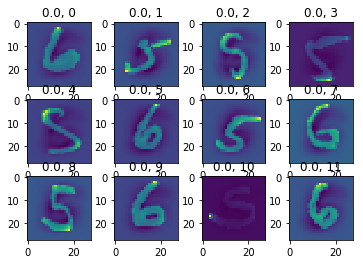

In [13]:
n = 4
for i in range(n*(n-1)):
    plt.subplot(n-1, n, i+1)
    q=np.random.randint(0, train_data.shape[0])
    plt.imshow(train_data[i].reshape(28,28))
    plt.title("%.1f, %d" % (0, i))

In [14]:
class net2:
    def __init__(self):
        self.d1 = Dense.Dense(28*28, 1, 0.01)
        self.a1 = Sigmoid.Sigmoid()

        self.loss_ = LogLoss.LogLoss()
    
    def loss(self, x, y):
        return self.loss_.forward(x, y)
    
    def forward(self, data, label=None):
        x = data * (label if label is not None else 1) #multiply be label or copy
        x = self.d1.forward(x)
        x = self.a1.forward(x)
        if label is None:
            return x
        return self.loss_.forward(x, label)
    
    def backward(self):
        loss = self.loss_.backward()
        loss = self.a1.backward(loss)
        loss = self.d1.backward(loss)
        
        
        
class net3:
    def __init__(self):
        self.d1 = Dense.Dense(28*28, 10, 0.01)
        self.a1 = Sigmoid.Sigmoid()
        self.d2 = Dense.Dense(10, 1, 0.01)
        self.a2 = Sigmoid.Sigmoid()
        self.loss_ = LogLoss.LogLoss()
    
    def loss(self, x, y):
        return self.loss_.forward(x, y)
    
    def forward(self, x, y=None):
        
        if y is not None:
            tmp = x * y
        else:
            tmp = x
        tmp = self.d1.forward(tmp)
        tmp = self.a1.forward(tmp)
        tmp = self.d2.forward(tmp)
        tmp = self.a2.forward(tmp)
        if y is None:
            return tmp
        return self.loss_.forward(tmp, y)
    
    def backward(self):
        loss = self.loss_.backward()
        loss = self.a2.backward(loss)
        loss = self.d2.backward(loss)
        loss = self.a1.backward(loss)
        loss = self.d1.backward(loss)
        
my_first_model = net2()

In [15]:
# Реализуйте здесь обучение модели
import time
#print(my_first_net.shape, 3)
start = time.monotonic()
test_loss = 1
min_loss = 1
end = start
epochs = 0
while(test_loss > 0 and end - start < 300 and epochs < 10):
    #train
    for i in range(train_data.shape[0]):
        chosen_index = np.random.randint(0, train_data.shape[0])
        my_first_model.forward(train_data[chosen_index], train_labels[chosen_index])
        my_first_model.backward()
    
    #loss & acc on train
    loss = 0
    right_answers = 0
    for i in range(train_data.shape[0]):
        net_answer = my_first_model.forward(train_data[i])
        if ((net_answer < 0.5 and train_labels[i] == 0) or (net_answer > 0.5 and train_labels[i] > 0)):
            right_answers +=1
        loss = my_first_model.loss(net_answer, train_labels[i])
    tr_eval.append([loss / train_data.shape[0], right_answers / train_data.shape[0]])
    
    #loss & acc on test
    test_loss = 0
    right_answers = 0
    for i in range(test_data.shape[0]):
        net_answer = my_first_model.forward(test_data[i])
        if ((net_answer < 0.5 and test_labels[i] == 0) or (net_answer > 0.5 and test_labels[i] > 0)):
            right_answers +=1
        loss = my_first_model.loss(net_answer, test_labels[i])
        #print(loss)
        test_loss += loss
    test_loss = loss / test_data.shape[0]
    te_eval.append([test_loss, 100 * right_answers / test_data.shape[0]])
    
    #loss output
    if test_loss < min_loss:
        min_loss = test_loss
        print(min_loss)
    end = time.monotonic()
    print('time is  : {:>9.2f}'.format(end - start))
    epochs += 1
    
#plt.imshow(my_first_model.d1.mt.reshape(28,28))
end = time.monotonic()
print('time is  : {:>9.2f}'.format(end - start))
#print(right_answers, test_loss)

0.001679349692937819
time is  :      1.19
time is  :      2.36
time is  :      3.54
time is  :      4.71
time is  :      5.88
time is  :      7.07
time is  :      8.24
time is  :      9.42
time is  :     10.61
time is  :     11.79
time is  :     11.79


10


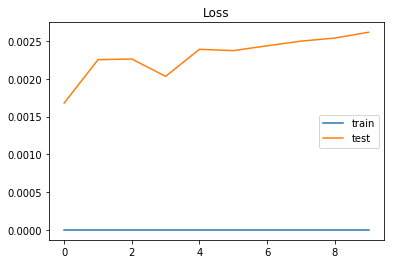

In [16]:
plt.title('Loss')
print(len(tr_eval))
plt.plot([e[0] for e in tr_eval], label='train')
plt.plot([e[0] for e in te_eval], label='test')
plt.legend()

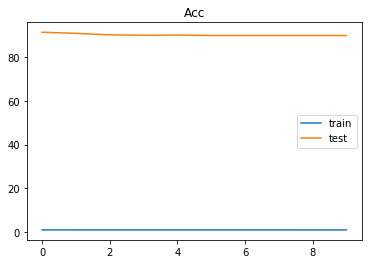

In [17]:
plt.title('Acc')
plt.plot([e[1] for e in tr_eval], label='train')
plt.plot([e[1] for e in te_eval], label='test')
plt.legend()

In [18]:
X = test_no_lables['data']
mean = np.mean(X, axis = 0)
std = np.std(X, axis = 0)
X_new = (X - mean) / (std + 0.00001)

# compute Y_pred
Y_pred = []
for i in range(X_new.shape[0]):
    net_response = my_first_model.forward(X_new[i])
    Y_pred.append(net_response)

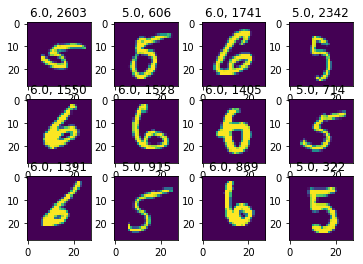

In [22]:
n = 4
for i in range(n*(n-1)):
    plt.subplot(n-1, n, i+1)
    q=np.random.randint(0, X.shape[0])
    plt.imshow(X[q].reshape(28,28))
    plt.title("%.1f, %d" % (my_first_model.forward(X_new[q])+5, q))

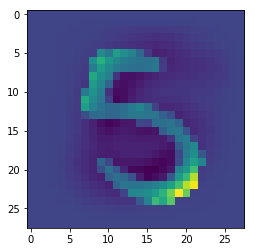

In [23]:
plt.imshow(train_data[3349].reshape(28,28))

Text(0.5, 1.0, '[[6.]]')

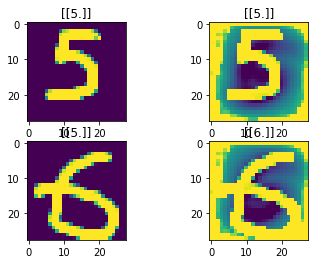

In [70]:
img1 = PIL.Image.open('tmp.bmp').convert('L')
img1 = np.array(img1)
img1 = 256-img1
img1 = img1.reshape(-1)
img1loaded = (img1 - mean)/(std + 1e-5)

res1 = my_first_model.forward(img1)+5
res1_ = my_first_model.forward(img1loaded)+5

plt.subplot(2, 2, 1)
plt.imshow(img1.reshape(28,28))
plt.title(res1)
plt.subplot(2, 2, 2)
plt.imshow(img1loaded.reshape(28,28), vmin=-1, vmax=1)
plt.title(res1_)

img2 = PIL.Image.open('tmp2.bmp').convert('L')
img2 = np.array(img2)
img2 = 256-img2
img2 = img2.reshape(-1)
img2loaded = (img2 - mean)/(std + 1e-5)

res2= my_first_model.forward(img2)+5
res2_ = my_first_model.forward(img2loaded)+5

plt.subplot(2, 2, 3)
plt.imshow(img2.reshape(28,28))
plt.title(res2)
plt.subplot(2, 2, 4)
plt.imshow(img2loaded.reshape(28,28), vmin=-1, vmax=1)
plt.title(res2_)

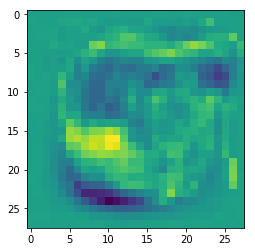

In [69]:
plt.imshow(my_first_model.d1.mt.reshape(28,28))
